In [5]:
using LinearAlgebra, Plots, Statistics, ForwardDiff, Distances
using LogExpFunctions, BenchmarkTools

In [7]:
include("../src/costs.jl")
include("../src/caches.jl")
include("../src/utilities.jl")
include("../src/sinkhorn_log.jl")

wasserstein_barycenter_log (generic function with 1 method)

In [50]:
c = (x,y) -> sqeuclidean(x,y)

n = 100

x = zeros(n,2)
y = zeros(n,2)

for i in 1:n
    x[i,:] .= rand(2)
    y[i,:] .= rand(2) .- [1,1]
end

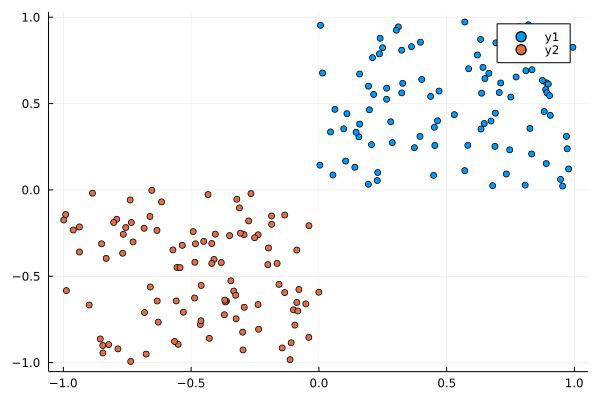

In [51]:
scatter( [ (x[i,1], x[i,2]) for i in 1:n ] )
scatter!( [ (y[i,1], y[i,2]) for i in 1:n ] )

In [52]:
log_α = [ log(1/n) for _ in 1:n ]
log_β = copy(log_α);

caches = ( VC = VectorCache(2,n),  )

ε = 1e-2

SP = SinkhornParameters(64, ε);

SP.debias = true

u₀ = zeros(n)
v₀ = zeros(n)
log_d₁₀ = zeros(n)
log_d₂₀ = zeros(n);

In [53]:
function loss(x)
    sinkhorn_dvg_particles( x, y, log_α, log_β, c,
                            u₀, v₀, log_d₁₀, log_d₂₀,
                            SP, caches  )
end

loss (generic function with 1 method)

In [54]:
using ForwardDiff

In [61]:
loss(x)

2.0285195562861267

In [62]:
dx = ForwardDiff.gradient(loss, x);

In [63]:
x₊ = x - dx;

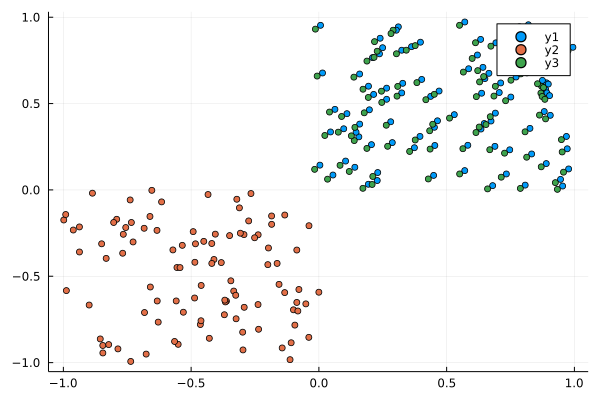

In [64]:
scatter( [ (x[i,1], x[i,2]) for i in 1:n ] )
scatter!( [ (y[i,1], y[i,2]) for i in 1:n ] )
scatter!( [ (x₊[i,1], x₊[i,2]) for i in 1:n ] )